## Market Movement Prediction Strategy: Create Buy Signal from Forecasted Probability of Log Return Increase

### Written: Eddie Taylor


In [11]:
import random
import numpy as np
import yfinance as yf
import pandas as pd
from matplotlib import style
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense 
from tensorflow.keras.optimizers import Adam, RMSprop
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from catboost import Pool, CatBoostClassifier, cv, CatBoostRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
style.use('dark_background')

[*********************100%***********************]  4 of 4 completed


<AxesSubplot:xlabel='Date'>

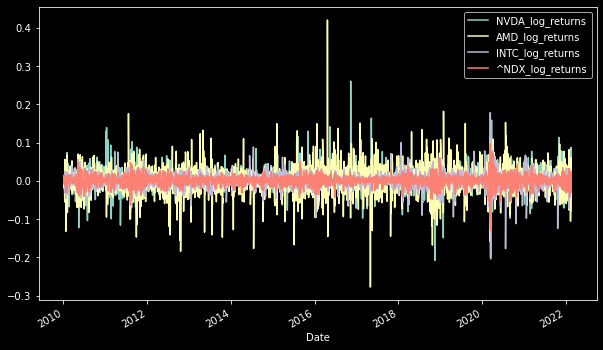

In [12]:
# Lets analyze Nvidia. We know from quick lookup of Nvidia news
# that Intel performance is connected to its performance, in addition to AMD.
# (source: https://www.barrons.com/articles/nvidia-intels-report-is-a-great-leading-indicator-says-raymond-james-1525724415)
# NDX is the index for the technology sector.
tickers = ['^NDX', 'INTC', 'AMD', 'NVDA']
data = (yf.download(tickers, start='2010-01-01', end='2022-02-18')
            .drop(columns = ['Close','Open','High','Low','Volume'])
)
data.columns = data.columns.droplevel()

for i in tickers:
    data[f'{i}_log_returns'] = (data[i].pct_change() + 1).apply(np.log)
data.tail()
data.plot(y=['NVDA_log_returns','AMD_log_returns','INTC_log_returns','^NDX_log_returns'], 
        use_index=True, figsize=(10,6))
# log returns quickly and efficiently detrends the pricing history

### **Feature Engineering**

#### Direction Feature

In [13]:
# lets define a direction column which is essentially 1 if the log return is positive and 0 if
# it is negative (classification tasks typically have a target variable which is 1 or 0)
for i in tickers:
    data[f'{i}_direction'] = np.where(data[f'{i}_log_returns'] > 0, 1, 0)
data.tail()

,AMD,INTC,NVDA,^NDX,^NDX_log_returns,INTC_log_returns,AMD_log_returns,NVDA_log_returns,^NDX_direction,INTC_direction,AMD_direction,NVDA_direction
Date,,,,,,,,,,,,
2022-02-11,113.180000,47.630001,239.490005,14253.839844,-0.031205,-0.025496,-0.105475,-0.075378,0,0,0,0
2022-02-14,114.269997,47.580002,242.669998,14268.589844,0.001034,-0.001050,0.009585,0.013191,1,0,1,1
2022-02-15,121.470001,48.439999,264.950012,14620.820312,0.024386,0.017913,0.061103,0.087839,1,1,1,1
2022-02-16,117.690002,48.230000,265.109985,14603.639648,-0.001176,-0.004345,-0.031613,0.000604,0,0,0,1
2022-02-17,112.370003,47.570000,245.070007,14171.740234,-0.030021,-0.013779,-0.046257,-0.078601,0,0,0,0


#### Lag Features

/home/eddie/miniconda3/envs/securities-analysis/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


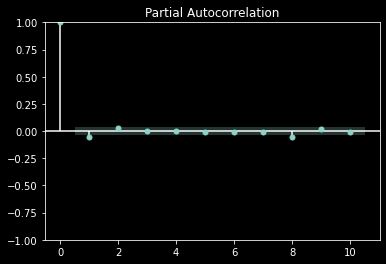

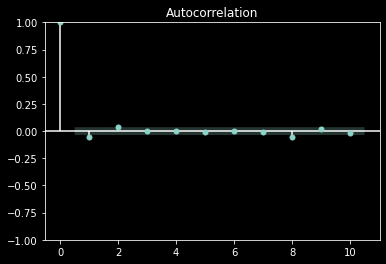

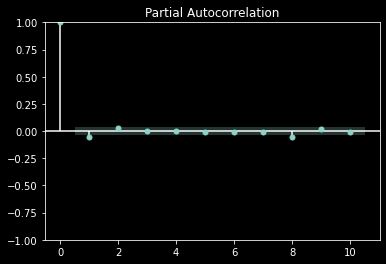

In [14]:
# traditionally to determine optimal lags of the target variable, we look at the autocorrelation 
# and partial autocorrelation of the target variable
plot_acf(data['NVDA_direction'], lags=10)
plot_pacf(data['NVDA_direction'], lags=10)

# looking at these plots, lagging the target variable probably won't help us

In [15]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	features = data.columns
	df = data
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [(f'{j}(t-{i})') for j in features]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [(f'{j}(t)') for j in features]
		else:
			names += [(f'{j}(t+{i})') for j in features]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# essentially build a forecast which predicts tomorrow. Excessive lagging of features but its fine because we can 
# examine the feature importance after modelling.
data = series_to_supervised(data)
data.tail()

,AMD(t-1),INTC(t-1),NVDA(t-1),^NDX(t-1),^NDX_log_returns(t-1),INTC_log_returns(t-1),AMD_log_returns(t-1),NVDA_log_returns(t-1),^NDX_direction(t-1),INTC_direction(t-1),...,NVDA(t),^NDX(t),^NDX_log_returns(t),INTC_log_returns(t),AMD_log_returns(t),NVDA_log_returns(t),^NDX_direction(t),INTC_direction(t),AMD_direction(t),NVDA_direction(t)
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-11,125.769997,48.860001,258.239990,14705.639648,-0.023609,-0.021262,-0.054766,-0.033547,0.0,0.0,...,239.490005,14253.839844,-0.031205,-0.025496,-0.105475,-0.075378,0,0,0,0
2022-02-14,113.180000,47.630001,239.490005,14253.839844,-0.031205,-0.025496,-0.105475,-0.075378,0.0,0.0,...,242.669998,14268.589844,0.001034,-0.001050,0.009585,0.013191,1,0,1,1
2022-02-15,114.269997,47.580002,242.669998,14268.589844,0.001034,-0.001050,0.009585,0.013191,1.0,0.0,...,264.950012,14620.820312,0.024386,0.017913,0.061103,0.087839,1,1,1,1
2022-02-16,121.470001,48.439999,264.950012,14620.820312,0.024386,0.017913,0.061103,0.087839,1.0,1.0,...,265.109985,14603.639648,-0.001176,-0.004345,-0.031613,0.000604,0,0,0,1
2022-02-17,117.690002,48.230000,265.109985,14603.639648,-0.001176,-0.004345,-0.031613,0.000604,0.0,0.0,...,245.070007,14171.740234,-0.030021,-0.013779,-0.046257,-0.078601,0,0,0,0


#### Date Features

In [16]:
data.reset_index(inplace=True)
data['year'] = data.Date.dt.year
data['month'] = data.Date.dt.month 
data['day'] = data.Date.dt.day
data['week'] = data.Date.dt.isocalendar().week
data['quarterstart'] = data.Date.dt.is_quarter_start.astype(int)
data['quarterend'] = data.Date.dt.is_quarter_end.astype(int)
data['dow'] = data.Date.dt.dayofweek
data['quarter'] = data.Date.dt.quarter
data.head()

,Date,AMD(t-1),INTC(t-1),NVDA(t-1),^NDX(t-1),^NDX_log_returns(t-1),INTC_log_returns(t-1),AMD_log_returns(t-1),NVDA_log_returns(t-1),^NDX_direction(t-1),...,AMD_direction(t),NVDA_direction(t),year,month,day,week,quarterstart,quarterend,dow,quarter
0,2010-01-06,9.71,14.459596,4.308283,1888.430054,0.000917,-0.000479,0.001030,0.014497,1.0,...,0,1,2010,1,6,1,0,0,2,1
1,2010-01-07,9.57,14.411103,4.335841,1878.420044,-0.005315,-0.003359,-0.014523,0.006376,0.0,...,0,0,2010,1,7,1,0,0,3,1
2,2010-01-08,9.47,14.272534,4.250871,1876.719971,-0.000905,-0.009662,-0.010504,-0.019792,0.0,...,0,1,2010,1,8,1,0,0,4,1
3,2010-01-11,9.43,14.431885,4.260056,1892.589966,0.008421,0.011103,-0.004233,0.002159,1.0,...,0,0,2010,1,11,2,0,0,0,1
4,2010-01-12,9.14,14.515029,4.200348,1886.239990,-0.003361,0.005745,-0.031236,-0.014115,0.0,...,0,0,2010,1,12,2,0,0,1,1


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3052 entries, 0 to 3051
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   3052 non-null   datetime64[ns]
 1   AMD(t-1)               3052 non-null   float64       
 2   INTC(t-1)              3052 non-null   float64       
 3   NVDA(t-1)              3052 non-null   float64       
 4   ^NDX(t-1)              3052 non-null   float64       
 5   ^NDX_log_returns(t-1)  3052 non-null   float64       
 6   INTC_log_returns(t-1)  3052 non-null   float64       
 7   AMD_log_returns(t-1)   3052 non-null   float64       
 8   NVDA_log_returns(t-1)  3052 non-null   float64       
 9   ^NDX_direction(t-1)    3052 non-null   float64       
 10  INTC_direction(t-1)    3052 non-null   float64       
 11  AMD_direction(t-1)     3052 non-null   float64       
 12  NVDA_direction(t-1)    3052 non-null   float64       
 13  AMD

#### Modelling

In [26]:
X, y = data.loc[:, data.columns != 'NVDA_direction(t)'], data.loc[:, 'NVDA_direction(t)']
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.90, random_state=1234)

In [28]:
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)
# not very imbalanced

1    0.53268
0    0.46732
Name: NVDA_direction(t), dtype: float64

In [29]:
# lets create a basic neural network

# instantiate the optimizer and set the random seed
optimizer = Adam(learning_rate=0.0001)

def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

set_seeds()

nn_model = Sequential()
nn_model.add(Dense(64, activation='relu',
input_shape=(X.shape[1],)))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))
nn_model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])